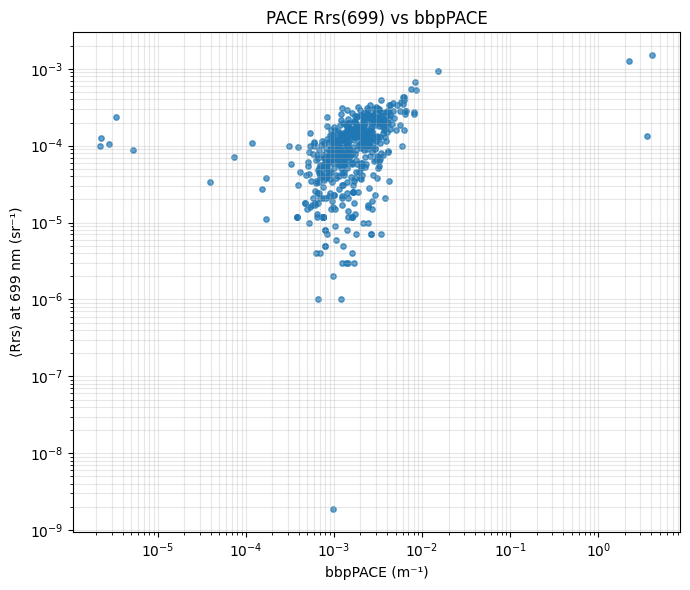

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Paths ===
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# === Load ===
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)

# === Merge keys ===
for c in ("wmo","cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

# === Choose bbpPACE column ===
bbp_col = "Bnw"  # change if different

# === Merge ===
mm = m.merge(r[["wmo","cycle","rrs700","wl_selected_nm","granule"]],
             on=["wmo","cycle"], how="left")

# === Clean numeric arrays ===
x = pd.to_numeric(mm[bbp_col], errors="coerce")
y = pd.to_numeric(mm["rrs700"], errors="coerce")
mask = x.notna() & y.notna() & (x > 0) & (y > 0)
x, y = x[mask], y[mask]

# === Scatter only ===
plt.figure(figsize=(7,6))
plt.scatter(x, y, s=15, alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("bbpPACE (m⁻¹)")
plt.ylabel("⟨Rrs⟩ at 699 nm (sr⁻¹)")
plt.title("PACE Rrs(699) vs bbpPACE")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

Using Argo bbp column: bbp_first3_mean


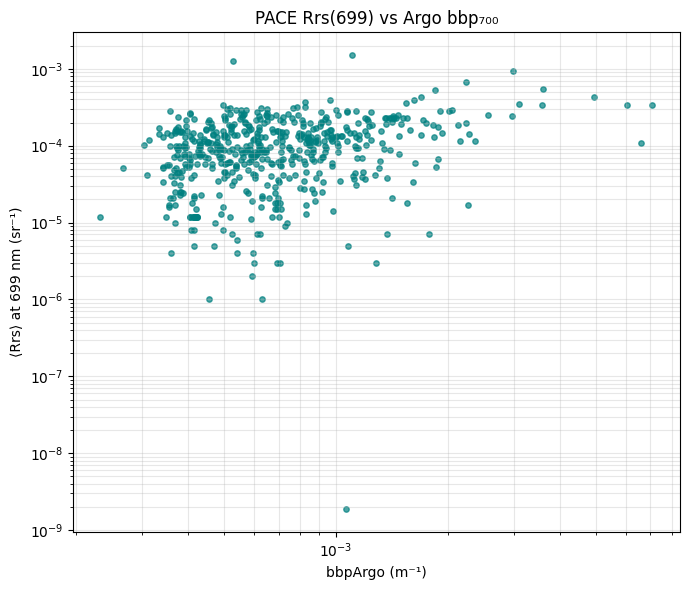

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Paths ===
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# === Load ===
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)

# === Merge keys ===
for c in ("wmo","cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

# === Identify Argo bbp column ===
argo_cols = [c for c in m.columns if "bbp" in c.lower() and "argo" in c.lower()]
if not argo_cols:
    # fallback: most likely column name in your file
    argo_cols = [c for c in m.columns if "bbp_first3" in c.lower() or "bbp700" in c.lower()]
if not argo_cols:
    raise KeyError("Could not find Argo bbp column — please set argo_col manually below")

argo_col = argo_cols[0]   # or manually: argo_col = "bbp_first3_mean"

print(f"Using Argo bbp column: {argo_col}")

# === Merge datasets ===
mm = m.merge(r[["wmo","cycle","rrs700","wl_selected_nm","granule"]],
             on=["wmo","cycle"], how="left")

# === Clean numeric ===
x = pd.to_numeric(mm[argo_col], errors="coerce")
y = pd.to_numeric(mm["rrs700"], errors="coerce")
mask = x.notna() & y.notna() & (x > 0) & (y > 0)
x, y = x[mask], y[mask]

# === Scatter plot (log–log) ===
plt.figure(figsize=(7,6))
plt.scatter(x, y, s=15, alpha=0.7, c="teal")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("bbpArgo (m⁻¹)")
plt.ylabel("⟨Rrs⟩ at 699 nm (sr⁻¹)")
plt.title("PACE Rrs(699) vs Argo bbp₇₀₀")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

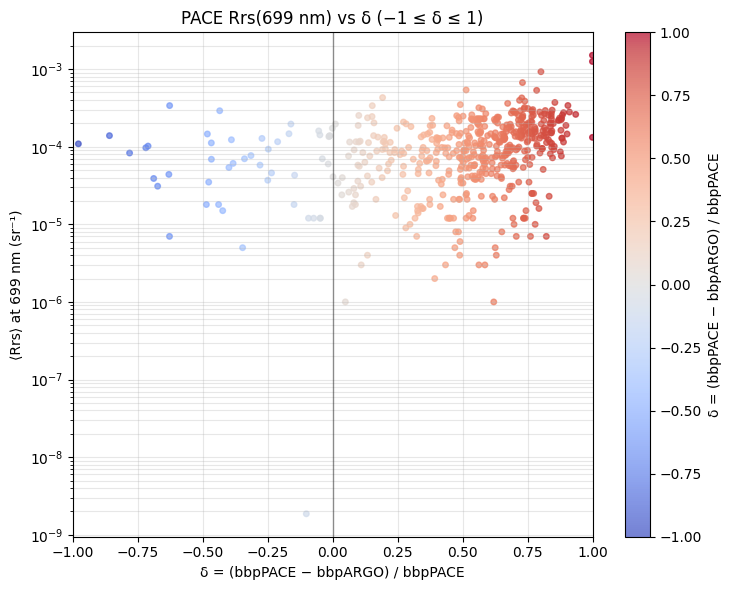

In [27]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# Paths
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# Load
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)
for c in ("wmo","cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

# Columns
bbp_pace_col = "Bnw"              # PACE bbp
argo_col     = "bbp_first3_mean"  # Argo bbp (set if different)

# Merge Rrs onto matched table
mm = m.merge(r[["wmo","cycle","rrs700","wl_selected_nm","granule"]],
             on=["wmo","cycle"], how="left")

pace = pd.to_numeric(mm[bbp_pace_col], errors="coerce")
argo = pd.to_numeric(mm[argo_col],      errors="coerce")
rrs  = pd.to_numeric(mm["rrs700"],      errors="coerce")

mask = np.isfinite(pace) & np.isfinite(argo) & np.isfinite(rrs) & (pace > 0) & (rrs > 0)
delta = (pace[mask] - argo[mask]) / pace[mask]
rrs_ok = rrs[mask]

# Restrict to −1 ≤ δ ≤ 1
clip_mask = (delta >= -1) & (delta <= 1)
delta, rrs_ok = delta[clip_mask], rrs_ok[clip_mask]

# Plot
plt.figure(figsize=(7.5, 6))
sc = plt.scatter(delta, rrs_ok, s=16, alpha=0.7,
                 c=delta, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(sc, label="δ = (bbpPACE − bbpARGO) / bbpPACE")

plt.yscale("log")
plt.xlim(-1, 1)
plt.grid(True, which="both", alpha=0.3)
plt.axvline(0, lw=1, color="k", alpha=0.4)

plt.xlabel("δ = (bbpPACE − bbpARGO) / bbpPACE")
plt.ylabel("⟨Rrs⟩ at 699 nm (sr⁻¹)")
plt.title("PACE Rrs(699 nm) vs δ (−1 ≤ δ ≤ 1)")

plt.tight_layout()
plt.show()

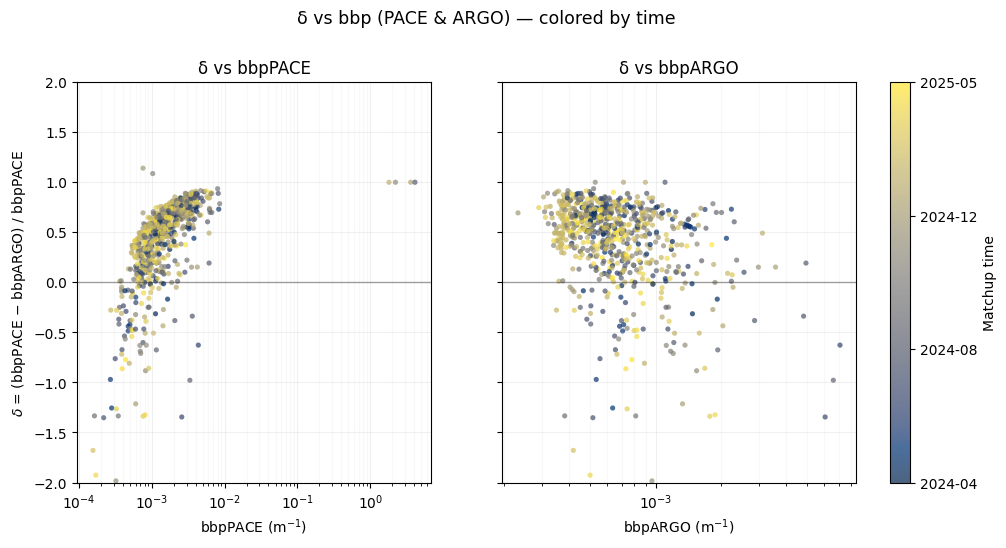

In [23]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator, NullFormatter
from pathlib import Path

# --- paths (adjust if needed) ---
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# --- load & merge ---
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)
for c in ("wmo","cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

bbp_pace_col = "Bnw"              # PACE bbp in your matched CSV
argo_col     = "bbp_first3_mean"  # ARGO surface first-3 mean
time_col     = "time" if "time" in m.columns else ("time" if "time" in r.columns else None)

mm = m.merge(r[["wmo","cycle","rrs700","wl_selected_nm","granule"]], on=["wmo","cycle"], how="left")

pace = pd.to_numeric(mm[bbp_pace_col], errors="coerce")
argo = pd.to_numeric(mm[argo_col], errors="coerce")

# time for coloring (quiet, subtle)
if time_col and time_col in mm.columns:
    t = pd.to_datetime(mm[time_col], errors="coerce", utc=True).dt.tz_convert(None)
    t_num = mdates.date2num(t)
else:
    t_num = np.full(len(mm), np.nan)

mask = np.isfinite(pace) & np.isfinite(argo)
delta = (pace[mask] - argo[mask]) / pace[mask]
bbp_pace = pace[mask]
bbp_argo = argo[mask]
t_num    = t_num[mask]

# clamp δ for readability
keep = (delta >= -2) & (delta <= 2)
delta, bbp_pace, bbp_argo, t_num = delta[keep], bbp_pace[keep], bbp_argo[keep], t_num[keep]

# color normalization
if np.all(~np.isfinite(t_num)):
    cmap, norm, colors = "cividis", Normalize(0, 1), np.zeros_like(delta)
    show_cbar = False
else:
    cmap = "cividis"     # subtle, perceptually uniform
    norm = Normalize(vmin=np.nanmin(t_num), vmax=np.nanmax(t_num))
    colors = t_num
    show_cbar = True

# ---- plotting ----
fig, axes = plt.subplots(1, 2, figsize=(11, 5.2), sharey=True)

common_scatter = dict(s=14, alpha=0.7, linewidths=0, c=colors, cmap=cmap, norm=norm)

# left: δ vs bbpPACE
sc1 = axes[0].scatter(bbp_pace, delta, **common_scatter)
axes[0].set_xscale("log")
axes[0].set_xlabel("bbpPACE (m$^{-1}$)")
axes[0].set_ylabel(r"$\delta$ = (bbpPACE − bbpARGO) / bbpPACE")
axes[0].set_title("δ vs bbpPACE", pad=6)

# right: δ vs bbpARGO
sc2 = axes[1].scatter(bbp_argo, delta, **common_scatter)
axes[1].set_xscale("log")
axes[1].set_xlabel("bbpARGO (m$^{-1}$)")
axes[1].set_title("δ vs bbpARGO", pad=6)

# y & grid styling
for ax in axes:
    ax.set_ylim(-2, 2)
    ax.axhline(0, color="k", lw=1, alpha=0.35)
    ax.grid(True, which="major", alpha=0.18)
    ax.grid(True, which="minor", alpha=0.08)
    ax.xaxis.set_minor_locator(LogLocator(subs=range(2, 10)))
    ax.xaxis.set_minor_formatter(NullFormatter())

# shared colorbar (time)
if show_cbar:
    cbar = fig.colorbar(sc2, ax=axes, fraction=0.046, pad=0.04)
    ticks = np.linspace(norm.vmin, norm.vmax, 4)  # fewer, cleaner ticks
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([mdates.num2date(tt).strftime("%Y-%m") for tt in ticks])
    cbar.set_label("Matchup time")

fig.suptitle("δ vs bbp (PACE & ARGO) — colored by time ", y=1.02, fontsize=12.5)
plt.show()

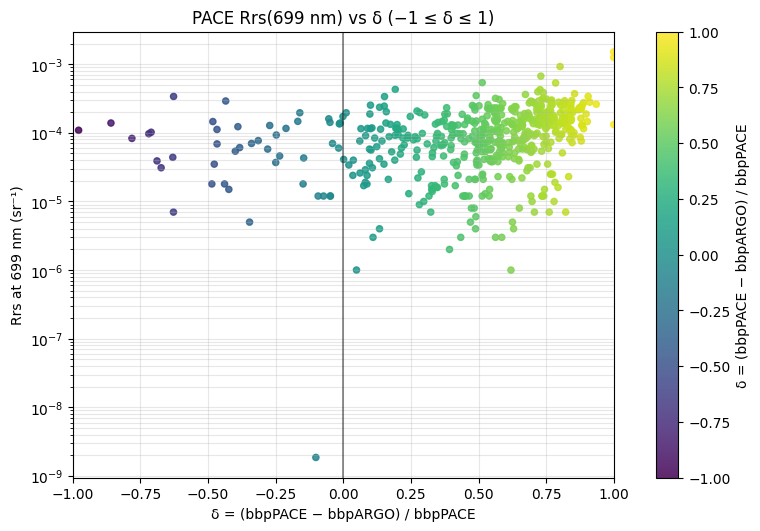

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pathlib import Path

# === Paths ===
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# === Load ===
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)

for c in ("wmo", "cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

# === Columns ===
bbp_pace_col = "Bnw"
argo_col     = "bbp_first3_mean"

# === Merge ===
mm = m.merge(r[["wmo","cycle","rrs700","wl_selected_nm","granule"]],
             on=["wmo","cycle"], how="left")

pace = pd.to_numeric(mm[bbp_pace_col], errors="coerce")
argo = pd.to_numeric(mm[argo_col], errors="coerce")
rrs  = pd.to_numeric(mm["rrs700"], errors="coerce")

# Compute δ
mask = np.isfinite(pace) & np.isfinite(argo) & np.isfinite(rrs) & (pace > 0) & (rrs > 0)
delta = (pace[mask] - argo[mask]) / pace[mask]
rrs_ok = rrs[mask]

# Clip to -1 ≤ δ ≤ 1
clip_mask = (delta >= -1) & (delta <= 1)
delta, rrs_ok = delta[clip_mask], rrs_ok[clip_mask]

# === Plot ===
fig, ax = plt.subplots(figsize=(7.5, 5.2), constrained_layout=True)

sc = ax.scatter(delta, rrs_ok, s=20, alpha=0.85,
                c=delta, cmap="viridis", vmin=-1, vmax=1)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("δ = (bbpPACE − bbpARGO) / bbpPACE")

ax.set_yscale("log")
ax.set_xlim(-1, 1)
ax.axvline(0, lw=1.2, color="k", alpha=0.5)
ax.grid(True, which="both", alpha=0.3)

ax.set_xlabel("δ = (bbpPACE − bbpARGO) / bbpPACE")
ax.set_ylabel("Rrs at 699 nm (sr⁻¹)")
ax.set_title("PACE Rrs(699 nm) vs δ (−1 ≤ δ ≤ 1)")

plt.show()

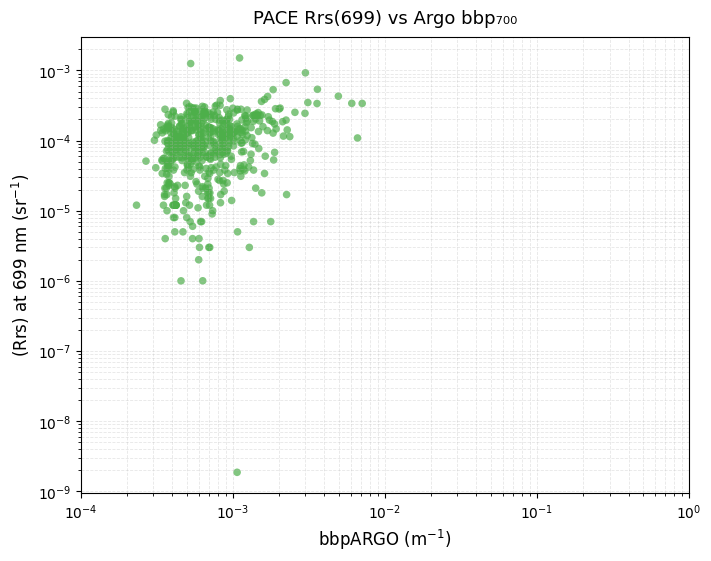

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# === File paths ===
ROOT = Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis"
matched_csv = ROOT / "matched_with_first3_added.csv"
rrs_csv     = ROOT / "pace_rrs700_by_matchup__filtered.csv"

# === Load data ===
m = pd.read_csv(matched_csv)
r = pd.read_csv(rrs_csv)

# Ensure merge keys are numeric
for c in ("wmo", "cycle"):
    if c in m: m[c] = pd.to_numeric(m[c], errors="coerce").astype("Int64")
    if c in r: r[c] = pd.to_numeric(r[c], errors="coerce").astype("Int64")

# Column references
bbp_argo_col = "bbp_first3_mean"   # Argo bbp700
rrs_col      = "rrs700"            # PACE Rrs(699 nm)

# Merge Rrs(699) values into matchup table
mm = m.merge(r[["wmo","cycle",rrs_col,"wl_selected_nm","granule"]],
             on=["wmo","cycle"], how="left")

# Extract numeric arrays
argo = pd.to_numeric(mm[bbp_argo_col], errors="coerce")
rrs  = pd.to_numeric(mm[rrs_col], errors="coerce")

# Keep valid data
mask = np.isfinite(argo) & np.isfinite(rrs) & (argo > 0) & (rrs > 0)
argo, rrs = argo[mask], rrs[mask]

# === Plot ===
fig, ax = plt.subplots(figsize=(7, 5.5), constrained_layout=True)

ax.scatter(argo, rrs, s=30, alpha=0.7, color="#4daf4a", edgecolor="none")

# Log scales
ax.set_xscale("log")
ax.set_yscale("log")

# Fixed x range to show all decades
ax.set_xlim(1e-4, 1e0)

# Format log ticks
ax.xaxis.set_major_locator(mticker.LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1, numticks=100))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

# Labels and title
ax.set_xlabel("bbpARGO (m$^{-1}$)", fontsize=12)
ax.set_ylabel("(Rrs) at 699 nm (sr$^{-1}$)", fontsize=12)
ax.set_title("PACE Rrs(699) vs Argo bbp₇₀₀", pad=10, fontsize=13)

# Grid and layout
ax.grid(True, which="both", alpha=0.3, linestyle="--", linewidth=0.6)
plt.show()